# Manutenção Preditiva (PdM)

O dataset de manutenção preditiva contém dados de 21 sensores e 3 configurações operacionais de turbinas aeronáuticas. A variável target fornecida indica a `RUL` (remaining useful life) do equipamento.

O objetivo deste experimento será determinar se estes equipamentos apresentarão alguma falha dentro da uma janela de tempo suficiente para que a sua manutenção seja realizada.

# Importa Bibliotecas

#### DLPy:
- https://sassoftware.github.io/python-dlpy/index.html
- https://github.com/sassoftware/python-dlpy

#### Swat: 
- https://sassoftware.github.io/python-swat/index.html
- https://github.com/sassoftware/python-swat

#### Exemplos:
- https://github.com/sassoftware/sas-viya-programming

In [1]:
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swat.cas.datamsghandlers as dmh
from swat import *
import dlpy
from dlpy.timeseries import plot_timeseries
from dlpy.splitting import two_way_split
from dlpy import Sequential
from dlpy.layers import * 
from dlpy.model import Optimizer, AdamSolver, Sequence
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
%matplotlib inline

# Parameters

In [2]:
period = 30
seq_len = 50

# Connect to SAS Viya

In [3]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Action Sets

In [4]:
sas.loadactionset('fedSql')

NOTE: Added action set 'fedSql'.


[actionset]

 'fedSql'

+ Elapsed: 0.00184s, sys: 0.002s, mem: 0.248mb

# Prepare Train Data

In [5]:
train = sas.read_csv('/sasdata/pdm/PM_train.txt', sep=' ', casout=CASTable(name='train', replace=True))
print(train.columns)
print(train.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(sasdemo).
NOTE: The table TRAIN has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'Unnamed: 26',
       'Unnamed: 27'],
      dtype='object')
(20631, 28)


In [6]:
train.altertable(columns=[{'name':'Unnamed: 26', 'drop':True},
                          {'name':'Unnamed: 27', 'drop':True}])
print(train.columns)
print(train.shape)

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')
(20631, 26)


In [7]:
sas.fedsql.execdirect(
    '''
    create table train {options replace=true} as select 
      a.*, 
      a."cycle" as "age", 
      b."max_cycle" - a."cycle" as "ttf", 
      case when b."max_cycle" - a."cycle" <= %d then 1 else 0 end as "nearfailure" 
    from train as a 
    left join (
      select 
        "id", 
        max("cycle") as "max_cycle" 
      from train 
      group by "id") as b 
    on a."id" = b."id"
    ''' % period)
print(train.columns)
print(train.shape)

NOTE: Table TRAIN was created in caslib CASUSER(sasdemo) with 20631 rows returned.
Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'age', 'ttf',
       'nearfailure'],
      dtype='object')
(20631, 29)


# Prepare Test Data

In [8]:
test = sas.read_csv('/sasdata/pdm/PM_test.txt', sep=' ', casout=CASTable(name='test', replace=True))
print(test.columns)
print(test.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(sasdemo).
NOTE: The table TEST has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'Unnamed: 26',
       'Unnamed: 27'],
      dtype='object')
(13096, 28)


In [9]:
test.altertable(columns=[{'name':'Unnamed: 26', 'drop':True},
                         {'name':'Unnamed: 27', 'drop':True}])
print(test.columns)
print(test.shape)

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')
(13096, 26)


In [10]:
truth = sas.read_csv('/sasdata/pdm/PM_truth.txt', sep=' ', casout=CASTable(name='truth', replace=True))
print(truth.columns)
print(truth.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table TRUTH in caslib CASUSER(sasdemo).
NOTE: The table TRUTH has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['id', 'more'], dtype='object')
(100, 2)


In [11]:
sas.fedsql.execdirect(
    '''
    create table test {options replace=true} as select
        a.*,
        a.cycle as "age",
        c.more + b.max_cycle - a.cycle as "ttf",
        case when c.more + b.max_cycle - a.cycle <= %d then 1 else 0 end as "nearfailure"
    from test as a
    left join (
        select 
            "id", 
            max("cycle") as "max_cycle" 
        from test 
        group by "id") as b 
    on a."id" = b."id"
    left join truth as c
    on a."id" = c."id"
    ''' % period)
print(test.columns)
print(test.shape)

NOTE: Table TEST was created in caslib CASUSER(sasdemo) with 13096 rows returned.
Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'age', 'ttf',
       'nearfailure'],
      dtype='object')
(13096, 29)


# List all series

In [12]:
series = train.columns.drop(['id','cycle','ttf']).values.tolist()
print(series)

# Preprocess Train and Validation Data

In [13]:
ts_train = dlpy.TimeseriesTable.from_table(train)
ts_train.shape

(20631, 29)

In [14]:
ts_train.timeseries_formatting(timeid='cycle',
                               timeseries=series)

NOTE: Timeseries formatting is completed.


In [15]:
ts_train.timeseries_accumlation(acc_interval='obs',
                                groupby='id')

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of obs


In [16]:
ts_train.prepare_subsequences(seq_len=seq_len, 
                              target='nearfailure', 
                              predictor_timeseries=series)

NOTE: timeseries subsequences are prepared with subsequence length = 50


In [17]:
ts_train.shape

(15631, 1305)

In [18]:
smp_train, smp_valid = two_way_split(ts_train, test_rate=10, seed=42, im_table=False, stratify_by='nearfailure')
print(smp_train.shape)
print(smp_valid.shape)

(14068, 1305)
(1563, 1305)


# Preprocess Test Data

In [19]:
ts_test = dlpy.TimeseriesTable.from_table(test)
ts_test.shape

(13096, 29)

In [20]:
ts_test.timeseries_formatting(timeid='cycle',
                               timeseries=series)

NOTE: Timeseries formatting is completed.


In [21]:
ts_test.timeseries_accumlation(acc_interval='obs',
                                groupby='id')

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of obs


In [22]:
ts_test.prepare_subsequences(seq_len=seq_len, 
                              target='nearfailure', 
                              predictor_timeseries=series)

NOTE: timeseries subsequences are prepared with subsequence length = 50


In [23]:
ts_test.shape

(8162, 1305)

# Model 1

In [29]:
name = 'lstm_001'

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


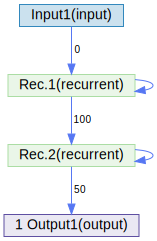

In [30]:
model = Sequential(sas, model_table=name)

model.add(InputLayer(std='STD'))
model.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=100, dropout=0.1, act='sigmoid'))
model.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=50, dropout=0.1, act='sigmoid'))
model.add(OutputLayer(n=1, full_connect=True, act='sigmoid', error='entropy'))

model.plot_network()

In [31]:
optimizer = Optimizer(algorithm=AdamSolver(), 
                      max_epochs=100, 
                      mini_batch_size=200,
                      seed=1234)

In [32]:
seq_spec  = Sequence(**ts_train.sequence_opt)

In [33]:
result = model.train(smp_train,
                     valid_table = smp_valid,
                     optimizer=optimizer,
                     sequence=seq_spec, 
                     **ts_train.inputs_target,
                     model=name,
                     model_weights=sas.CASTable(name+'_weights', replace=True))

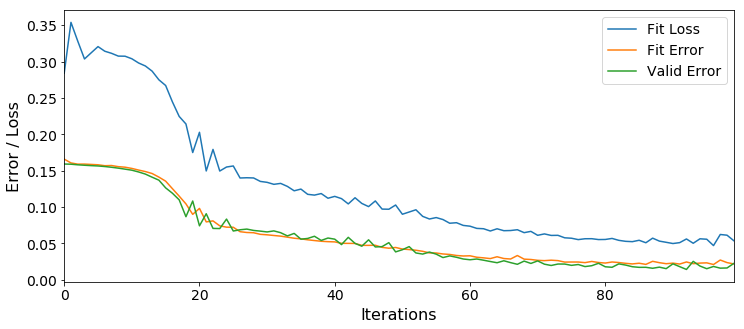

In [34]:
# model.plot_training_history(tick_frequency=1)
result.OptIterHistory[['Loss','FitError','ValidError']][0:].plot(figsize=(12,5))
ax = plt.gca()
ax.get_xaxis().set_tick_params(labelsize=14)
ax.get_yaxis().set_tick_params(labelsize=14)
ax.legend(['Fit Loss','Fit Error','Valid Error'], loc='upper right', prop={'size': 14})
ax.set_xlabel('Iterations',fontsize=16)
ax.set_ylabel('Error / Loss',fontsize=16)
plt.show()

In [35]:
result

,Descr,Value
0,Model Name,lstm_001
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,80900


# Model 2

In [26]:
name = 'lstm_002'

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


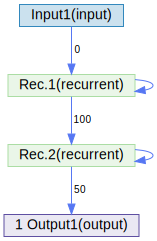

In [27]:
model = Sequential(sas, model_table=name)

model.add(InputLayer(std='STD'))
model.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=100, dropout=0.1, act='tanh'))
model.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=50, dropout=0.1, act='tanh'))
model.add(OutputLayer(n=1, full_connect=True, act='sigmoid', error='entropy'))

model.plot_network()

In [28]:
optimizer = Optimizer(algorithm=AdamSolver(), 
                      max_epochs=100, 
                      mini_batch_size=200,
                      seed=1234)

In [29]:
seq_spec  = Sequence(**ts_train.sequence_opt)

In [30]:
result = model.train(smp_train,
                     valid_table = smp_valid,
                     optimizer=optimizer,
                     sequence=seq_spec, 
                     **ts_train.inputs_target,
                     model=name,
                     model_weights=name+'_weights',
                     best_weights=name+'_weights_best')

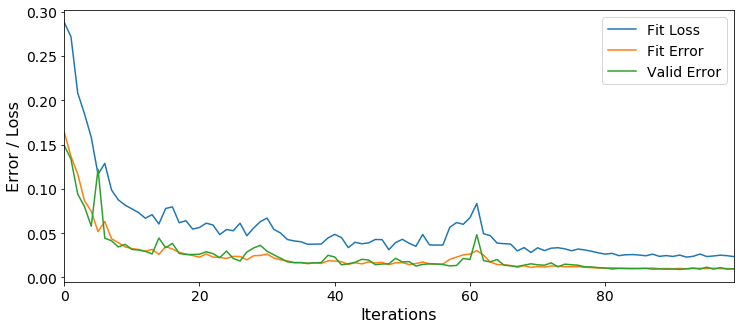

In [31]:
# model.plot_training_history(tick_frequency=1)
result.OptIterHistory[['Loss','FitError','ValidError']][0:].plot(figsize=(12,5))
ax = plt.gca()
ax.get_xaxis().set_tick_params(labelsize=14)
ax.get_yaxis().set_tick_params(labelsize=14)
ax.legend(['Fit Loss','Fit Error','Valid Error'], loc='upper right', prop={'size': 14})
ax.set_xlabel('Iterations',fontsize=16)
ax.set_ylabel('Error / Loss',fontsize=16)
plt.show()

In [32]:
result

,Descr,Value
0,Model Name,lstm_002
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,80900


# Evaluate

In [79]:
model.score(ts_test,
            model=name,
            init_weights=name+'_weights', 
            copy_vars=['id','cycle','nearfailure'],
            casout={'name':'lstm_pred', 'replace':True})

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          8162
 1  Number of Observations Used          8162
 2           Mean Squared Error      0.004631
 3                   Loss Error      0.010086

[OutputCasTables]

              casLib       Name  Rows  Columns  \
 0  CASUSER(sasdemo)  lstm_pred  8162        4   
 
                                            casTable  
 0  CASTable('lstm_pred', caslib='CASUSER(sasdemo)')  

+ Elapsed: 1.78s, user: 12s, sys: 0.061s, mem: 41.2mb

In [80]:
sas.fedsql.execdirect(
    '''
    create table lstm_pred {options replace=true} as select
       *,
       case when _DL_Pred_ < 0.5 then 0 else 1 end as nf_pred
    from lstm_pred
    ''')

NOTE: Table LSTM_PRED was created in caslib CASUSER(sasdemo) with 8162 rows returned.


+ Elapsed: 0.0356s, user: 0.053s, sys: 0.024s, mem: 26.2mb

In [81]:
pred = sas.CASTable('lstm_pred')

In [82]:
acc = accuracy_score(ts_test.nearfailure, pred.nf_pred, id_vars='id')
auc = roc_auc_score(ts_test.nearfailure, pred._DL_Pred_, id_vars='id', pos_label=1)
cmx = confusion_matrix(ts_test.nearfailure, pred.nf_pred, id_vars='id', labels=[0,1])

In [83]:
print('Accuracy Score: %.4f' % acc)
print('AUC Score: %.4f' % auc)
print('\nConfusion Matrix:\n%s' % cmx)

Accuracy Score: 0.9938
AUC Score: 0.9982

Confusion Matrix:
nf_pred           0      1
nearfailure               
0            7816.0   14.0
1              37.0  295.0


# Save Model

In [104]:
model.save_to_table('/sasdata/pdm')

NOTE: Model table saved successfully.


# Terminate SAS Viya Session

In [ ]:
sas.terminate()